Скачаем датасет с Kaggle (опционально)

In [ ]:
!pip install -q kaggle
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv 'kaggle (2).json' ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list -s "airbnb"
!kaggle datasets download -d joebeachcapital/airbnb
!unzip -q airbnb.zip

Saving kaggle (2).json to kaggle (2).json
ref                                                       title                                            size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -----------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
airbnb/seattle                                            Seattle Airbnb Open Data                     20410379  2018-06-26 04:29:12.570000          44333        431  0.7058824        
airbnb/boston                                             Boston Airbnb Open Data                      16893659  2019-11-17 21:30:47.763000          23543        221  0.7058824        
arianazmoudeh/airbnbopendata                              Airbnb Open Data                             10964528  2022-08-01 15:58:10.983000          45167        349  1.0              
erikbruin/airbnb-amsterdam       

Датасет: Airbnb Global Listings https://www.kaggle.com/datasets/joebeachcapital/airbnb

Цели нашей работы:
* Разведочный анализ данных (EDA) для понимания структуры и распределений

* Статистический анализ ключевых признаков

* Построение и оценка моделей для прогнозирования цены



В данном проекте проводится исследование датасета Airbnb с целью выявления факторов, влияющих на успешность размещений. Под успешностью понимается популярность объекта — например, высокая частота бронирований, большое количество отзывов или высокий средний рейтинг. Задача заключается в том, чтобы определить, какие характеристики объявления — такие как цена, расположение, тип жилья, наличие удобств или политика отмены — способствуют его привлекательности для гостей.

Исследование начинается с разведочного анализа данных (EDA), включающего оценку структуры датасета, выявление пропусков и выбросов, а также изучение распределений признаков. Особое внимание уделяется целевой переменной, отражающей успешность объекта размещения — это может быть, например, число отзывов в месяц или общий рейтинг.

На следующем этапе строятся модели машинного обучения, способные прогнозировать успешность жилья. В рамках работы используются два алгоритма классификации: логистическая регрессия и случайный лес.

Для оценки качества моделей применяется метрика ROC-AUC. Это позволяет объективно сравнить эффективность различных алгоритмов и выбрать наилучший вариант.

Предварительные гипотезы исследования заключаются в том, что такие факторы, как разумная цена, положительные отзывы, удачное местоположение и широкий набор удобств, положительно влияют на популярность объявления. Также предполагается, что опыт и активность хоста, гибкие условия отмены и невысокие требования к минимальному сроку аренды могут способствовать увеличению спроса.

Ожидаемый результат работы — выделение наиболее значимых факторов, определяющих успешность размещения, а также построение моделей, способных предсказывать популярность объектов на платформе Airbnb. Выводы будут подтверждены наглядными визуализациями, иллюстрирующими ключевые зависимости и важность признаков.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    RocCurveDisplay,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    mean_squared_error,
    r2_score
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv('airbnb-listings.csv', sep=';')

df.head()

<ipython-input-2-5c98af442252>:1: DtypeWarning: Columns (0,2,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('airbnb-listings.csv', sep=';')


,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,4008728,https://www.airbnb.com/rooms/4008728,20170402075052,2017-04-02,"Luxurious 3 bedroom, centrum, 180m2",‪This luxurious apartment is situated in the c...,In the heart of hip & lively Amsterdam Centrum...,‪This luxurious apartment is situated in the c...,none,There is a wide variety of cafes and restauran...,...,10.0,10.0,9.0,NaN,Amsterdam,strict,1.0,1.52,"52.36523660409065, 4.878249575101092","Host Has Profile Pic,Host Identity Verified,Is..."
1,7778612,https://www.airbnb.com/rooms/7778612,20170402075052,2017-04-02,Luxury apartment in city centre,"Beautiful, large (105m2, 2 floors) and quiet a...",1 living room 1 dining room 2 bedrooms 1 bathr...,"Beautiful, large (105m2, 2 floors) and quiet a...",none,Within a few minutes walking you'll be in the ...,...,10.0,10.0,9.0,NaN,Amsterdam,strict,1.0,0.81,"52.367309030897516, 4.8738407410699915","Host Is Superhost,Host Has Profile Pic,Host Id..."
2,8264596,https://www.airbnb.com/rooms/8264596,20170402075052,2017-04-02,Cosy apartment across Vondelpark,This central located apartment will make you f...,NaN,This central located apartment will make you f...,none,NaN,...,10.0,10.0,10.0,NaN,Amsterdam,flexible,1.0,0.05,"52.361943953804776, 4.866686522141489","Host Has Profile Pic,Host Identity Verified,Is..."
3,2180729,https://www.airbnb.com/rooms/2180729,20170402075052,2017-04-02,Spacious City Apartment Oud-West,Living like an Amsterdam resident in this ligh...,There are 2 bedrooms each with a double bed. I...,Living like an Amsterdam resident in this ligh...,none,The 85 m2 apartment is located on a quiet stre...,...,9.0,9.0,9.0,NaN,Amsterdam,flexible,1.0,0.62,"52.37014616115532, 4.866281767968382","Host Has Profile Pic,Host Identity Verified,Is..."
4,14463171,https://www.airbnb.com/rooms/14463171,20170402075052,2017-04-02,Cosy Studio Apartment Center Amsterdam,Studio Apartment Centre Amsterdam Perfect stud...,NaN,Studio Apartment Centre Amsterdam Perfect stud...,none,NaN,...,8.0,9.0,9.0,NaN,Amsterdam,moderate,1.0,2.04,"52.368817829014425, 4.871249476925455",Host Has Profile Pic


Проанализиурем признаки на предмет корреляции с целевым признаком (ценой)

Почистим данные и выберем ключевые признаки:


In [ ]:
item0 = df.shape[0]
df = df.drop_duplicates()
item1 = df.shape[0]
print(f"There are {item0-item1} duplicates found in the dataset")

df = df[df['Price']>0]

replacement_dict = {'Αθήνα, Greece': 'Athens, Greece',
                    'Athina, Greece': 'Athens, Greece',
                    'Roma, Italy': 'Rome, Italy',
                    'Venezia, Italy': 'Venice, Italy',
                    'København, Denmark': 'Copenhagen, Denmark',
                    'Montréal, Canada': 'Montreal, Canada',
                    'Ville de Québec, Canada': 'Québec, Canada',
                    'Genève, Switzerland': 'Geneva, Switzerland',
                    'Palma, Spain': 'Palma de Mallorca, Spain',
                    'Wien, Austria': 'Vienna, Austria',
                    'Greater London, United Kingdom': 'London, United Kingdom'
                   }
df['Smart Location'] = df['Smart Location'].replace(replacement_dict).fillna('None').astype(str)

selected_cols = ['Price', 'Smart Location', 'Room Type', 'Property Type', 'Bed Type', 'Availability 365', 'Minimum Nights',
                 'Number of Reviews', 'Review Scores Rating', 'Cancellation Policy']
df = df[selected_cols]
print(df.shape)
df.sample(5).T

There are 0 duplicates found in the dataset
(486974, 10)


,448674,87938,220970,209873,259400
Price,60.0,89.0,61.0,130.0,18.0
Smart Location,"Rome, Italy","Portland, OR","Paris, France","Austin, TX","Barcelona, Spain"
Room Type,Private room,Private room,Entire home/apt,Entire home/apt,Private room
Property Type,Apartment,House,Apartment,Bungalow,Apartment
Bed Type,Real Bed,Real Bed,Couch,Real Bed,Real Bed
Availability 365,0.0,337.0,299.0,19.0,182.0
Minimum Nights,2.0,2.0,2.0,2.0,1.0
Number of Reviews,1.0,28.0,5.0,0.0,1.0
Review Scores Rating,100.0,96.0,92.0,NaN,100.0
Cancellation Policy,flexible_new,moderate,moderate,strict,strict


In [ ]:
text_cols = ['Room Type', 'Property Type', 'Bed Type', 'Cancellation Policy']
for col in text_cols:
    df[col] = df[col].fillna('Unknown').str.strip().str.title()

num_cols = ['Availability 365', 'Minimum Nights', 'Number of Reviews', 'Review Scores Rating']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

price_threshold = df['Price'].quantile(0.99)
df = df[df['Price'] <= price_threshold]

df = df[
    (df['Availability 365'] >= 0) &
    (df['Availability 365'] <= 365) &
    (df['Minimum Nights'] > 0) &
    (df['Review Scores Rating'] >= 0) &
    (df['Review Scores Rating'] <= 100)
].reset_index(drop=True)

print("\nСтатистика после очистки:")
print(f"Осталось записей: {df.shape[0]}")
print(f"Пропущенных значений:\n{df.isna().sum()}")

print("\nПроверка выбросов:")
print(df[['Price', 'Availability 365', 'Minimum Nights']].describe())

display(df.sample(5).T)


Статистика после очистки:
Осталось записей: 482322
Пропущенных значений:
Price                   0
Smart Location          0
Room Type               0
Property Type           0
Bed Type                0
Availability 365        0
Minimum Nights          0
Number of Reviews       0
Review Scores Rating    0
Cancellation Policy     0
dtype: int64

Проверка выбросов:
               Price  Availability 365  Minimum Nights
count  482322.000000     482322.000000   482322.000000
mean      130.720036        166.386093        3.469717
std       130.074250        140.351437       90.531430
min         1.000000          0.000000        1.000000
25%        55.000000         15.000000        1.000000
50%        90.000000        149.000000        2.000000
75%       150.000000        313.000000        3.000000
max       801.000000        365.000000    60000.000000


,27854,296821,274387,396320,54461
Price,62.0,95.0,40.0,90.0,130.0
Smart Location,"Washington, DC","London, United Kingdom","Paris, France","Montreal, Canada","Smithfield, Ireland"
Room Type,Private Room,Entire Home/Apt,Entire Home/Apt,Entire Home/Apt,Entire Home/Apt
Property Type,Apartment,Apartment,Apartment,Loft,Apartment
Bed Type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
Availability 365,4.0,82.0,0.0,242.0,106.0
Minimum Nights,1.0,1.0,5.0,2.0,2.0
Number of Reviews,8.0,0.0,1.0,0.0,33.0
Review Scores Rating,85.0,95.0,80.0,95.0,94.0
Cancellation Policy,Flexible,Flexible,Flexible,Flexible,Strict


In [ ]:
cols_to_clean = ['Room Type', 'Property Type', 'Bed Type', 'Cancellation Policy', 'Smart Location']

for col in cols_to_clean:
    if col in df.columns:

        df.drop(df[(df[col] == 'Unknown') | (df[col] == '9')].index, inplace=True)

        df.reset_index(drop=True, inplace=True)

Рассмотрим распределени ключевых признаков:

<ipython-input-9-e43d9f831174>:87: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


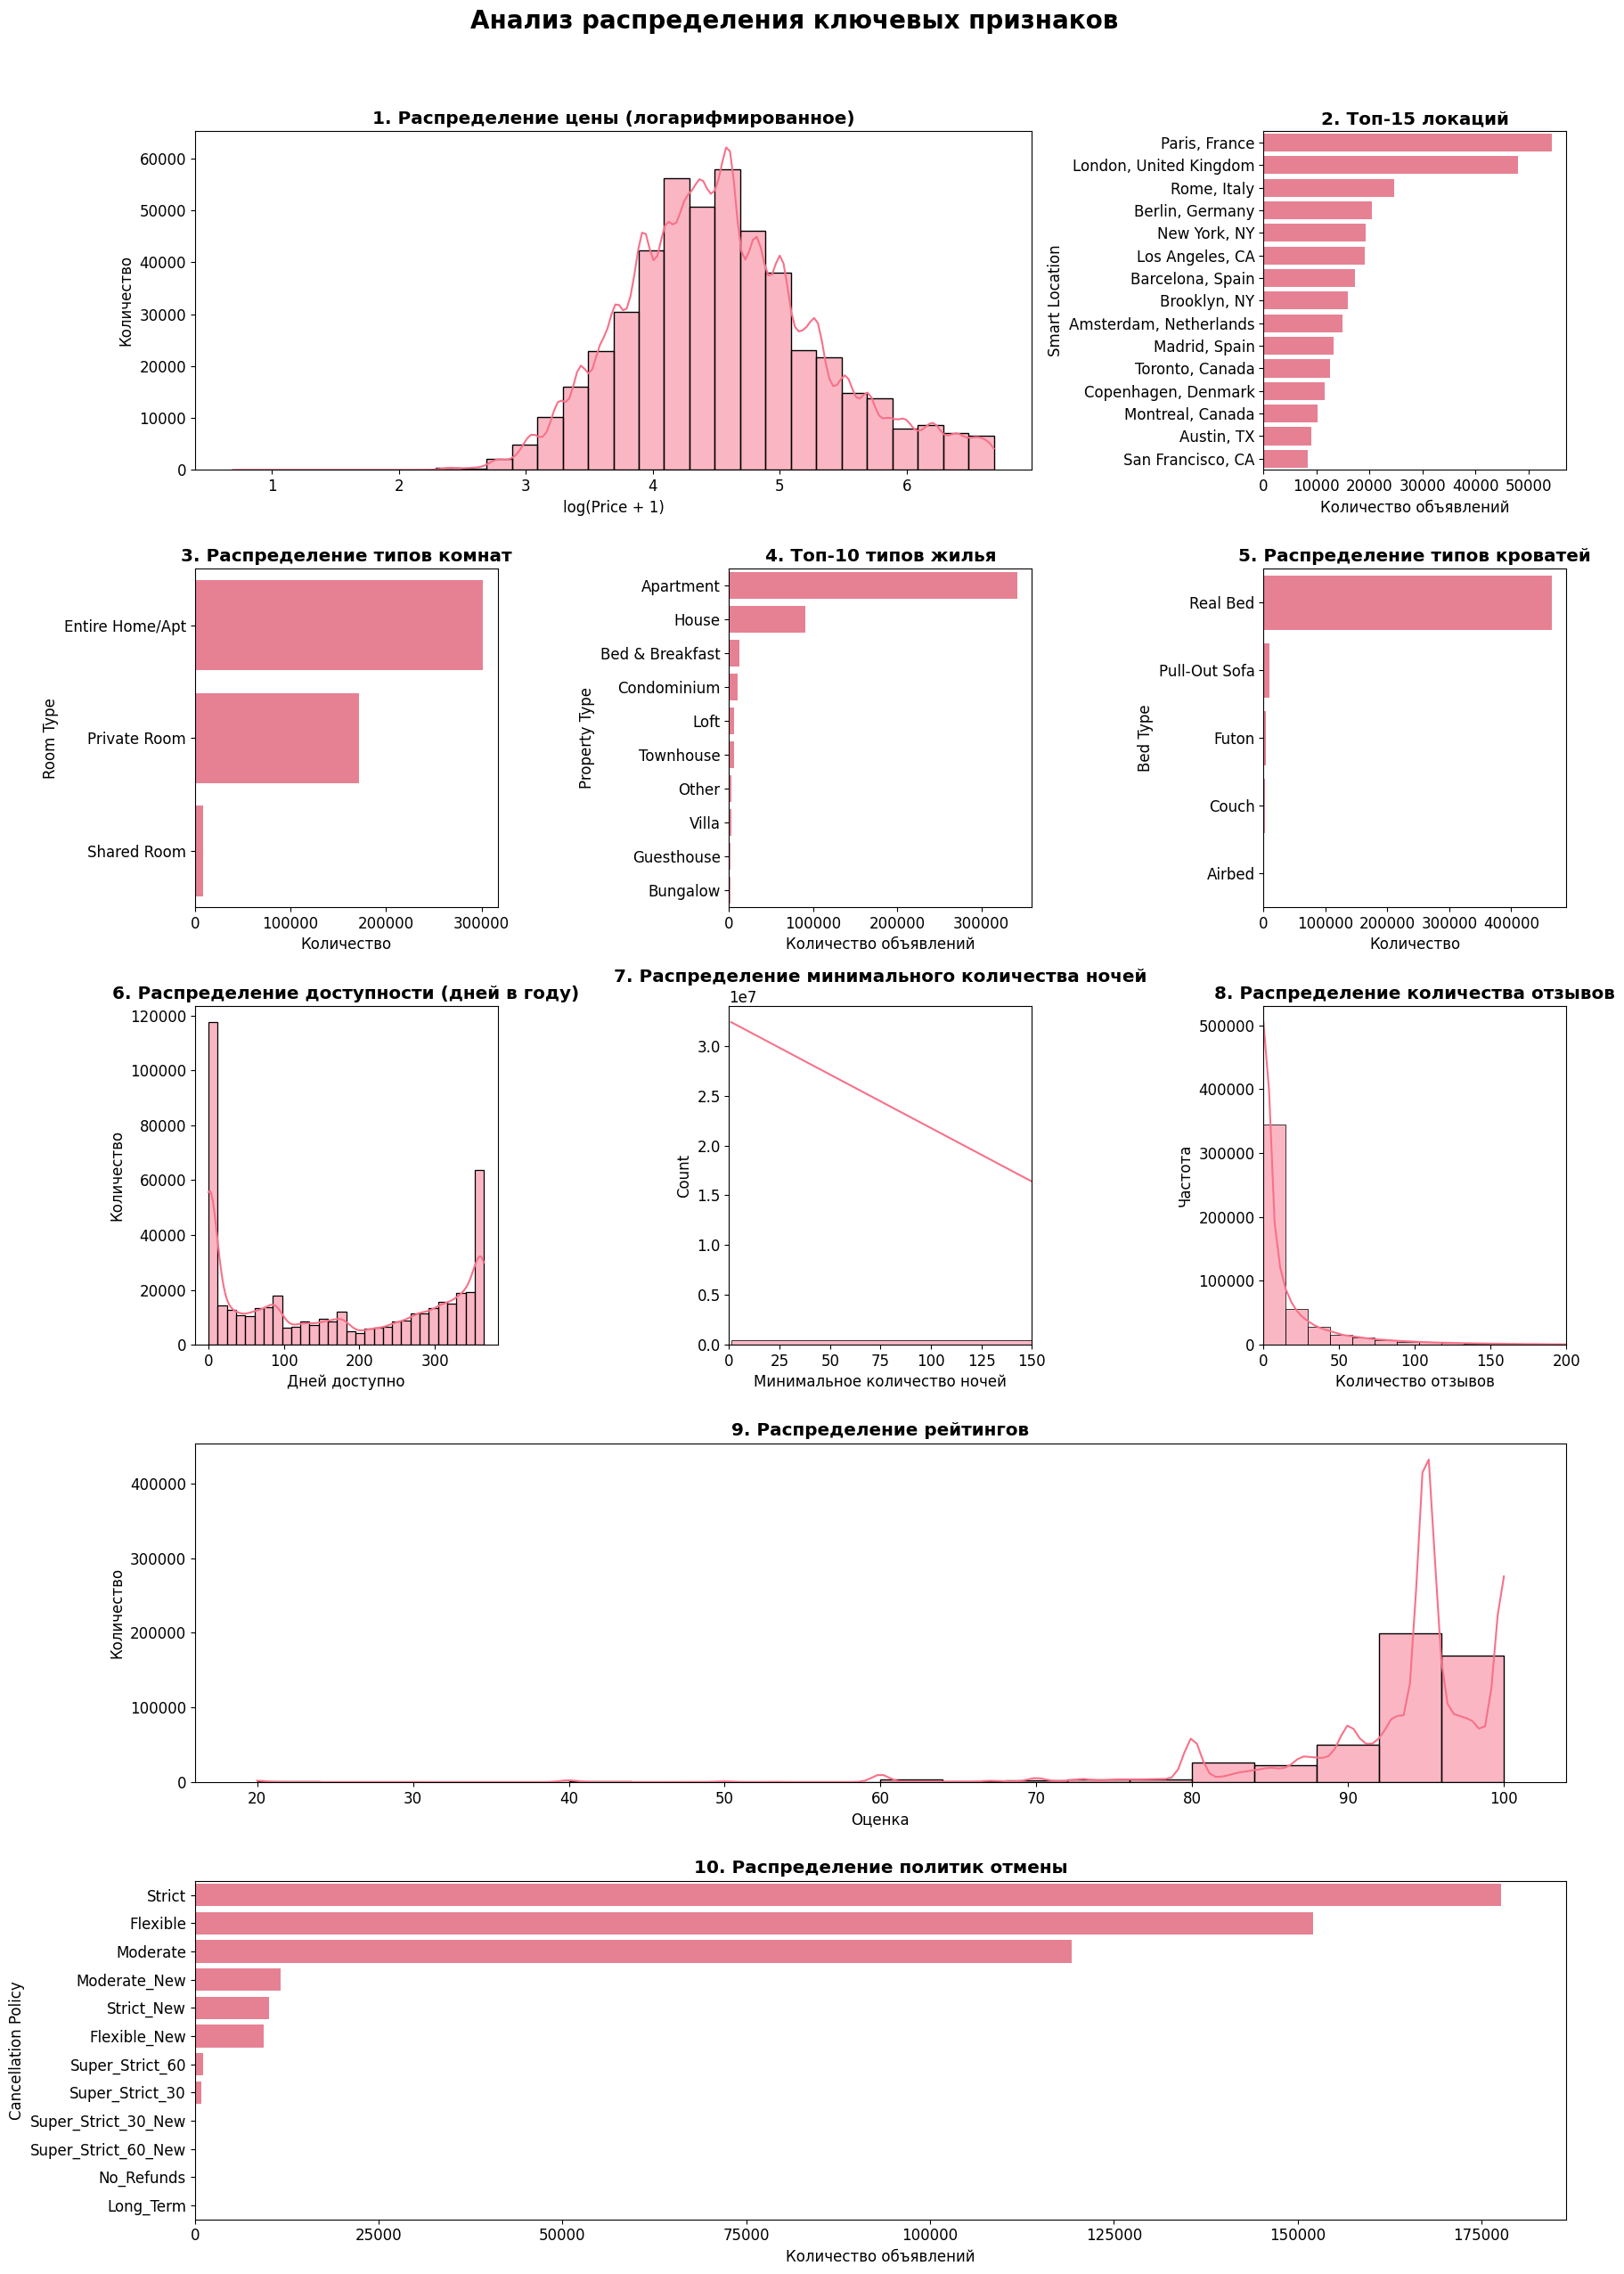

In [ ]:
sns.set_palette("husl")
plt.rcParams['font.size'] = 12

selected_cols = ['Price', 'Smart Location', 'Room Type', 'Property Type', 'Bed Type',
                'Availability 365', 'Minimum Nights', 'Number of Reviews',
                'Review Scores Rating', 'Cancellation Policy']

fig1 = plt.figure(constrained_layout=True, figsize=(18, 25))
gs = fig1.add_gridspec(5, 3)

# 1. Распределение цены
ax1 = fig1.add_subplot(gs[0, :2])
sns.histplot(np.log1p(df['Price']), bins=30, kde=True, ax=ax1)
ax1.set_title('1. Распределение цены (логарифмированное)', fontweight='bold')
ax1.set_xlabel('log(Price + 1)')
ax1.set_ylabel('Количество')

# 2. Топ-15 локаций
ax2 = fig1.add_subplot(gs[0, 2])
top_locations = df['Smart Location'].value_counts().head(15)
sns.barplot(x=top_locations.values, y=top_locations.index, ax=ax2)
ax2.set_title('2. Топ-15 локаций', fontweight='bold')
ax2.set_xlabel('Количество объявлений')

# 3. Распределение типов комнат
ax3 = fig1.add_subplot(gs[1, 0])
sns.countplot(y='Room Type', data=df, order=df['Room Type'].value_counts().index, ax=ax3)
ax3.set_title('3. Распределение типов комнат', fontweight='bold')
ax3.set_xlabel('Количество')

# 4. Топ-10 типов жилья
ax4 = fig1.add_subplot(gs[1, 1])
top_properties = df['Property Type'].value_counts().head(10)
sns.barplot(x=top_properties.values, y=top_properties.index, ax=ax4)
ax4.set_title('4. Топ-10 типов жилья', fontweight='bold')
ax4.set_xlabel('Количество объявлений')

# 5. Распределение типов кроватей
ax5 = fig1.add_subplot(gs[1, 2])
sns.countplot(y='Bed Type', data=df, order=df['Bed Type'].value_counts().index, ax=ax5)
ax5.set_title('5. Распределение типов кроватей', fontweight='bold')
ax5.set_xlabel('Количество')

# 6. Распределение доступности
ax6 = fig1.add_subplot(gs[2, 0])
sns.histplot(df['Availability 365'], bins=30, kde=True, ax=ax6)
ax6.set_title('6. Распределение доступности (дней в году)', fontweight='bold')
ax6.set_xlabel('Дней доступно')
ax6.set_ylabel('Количество')

# 7. Распределение минимального количества ночей
ax7 = fig1.add_subplot(gs[2, 1])
sns.histplot(df['Minimum Nights'], bins=50, kde=True, ax=ax7)
ax7.set_title('7. Распределение минимального количества ночей', fontweight='bold')
ax7.set_xlabel('Минимальное количество ночей')
ax7.set_xlim(0, 150)

# 8. Распределение количества отзывов
ax8 = fig1.add_subplot(gs[2, 2])
sns.histplot(df['Number of Reviews'], bins=50, kde=True, ax=ax8)
ax8.set_title('8. Распределение количества отзывов', fontweight='bold')
ax8.set_xlabel('Количество отзывов')
ax8.set_ylabel('Частота')
ax8.set_xlim(0, 200)

# 9. Распределение рейтингов
ax9 = fig1.add_subplot(gs[3, :])
sns.histplot(df['Review Scores Rating'].dropna(), bins=20, kde=True, ax=ax9)
ax9.set_title('9. Распределение рейтингов', fontweight='bold')
ax9.set_xlabel('Оценка')
ax9.set_ylabel('Количество')

# 10. Политики отмены
ax10 = fig1.add_subplot(gs[4, :])
policy_order = df['Cancellation Policy'].value_counts().index
sns.countplot(y='Cancellation Policy', data=df, order=policy_order, ax=ax10)
ax10.set_title('10. Распределение политик отмены', fontweight='bold')
ax10.set_xlabel('Количество объявлений')

plt.suptitle('Анализ распределения ключевых признаков', y=1.02, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

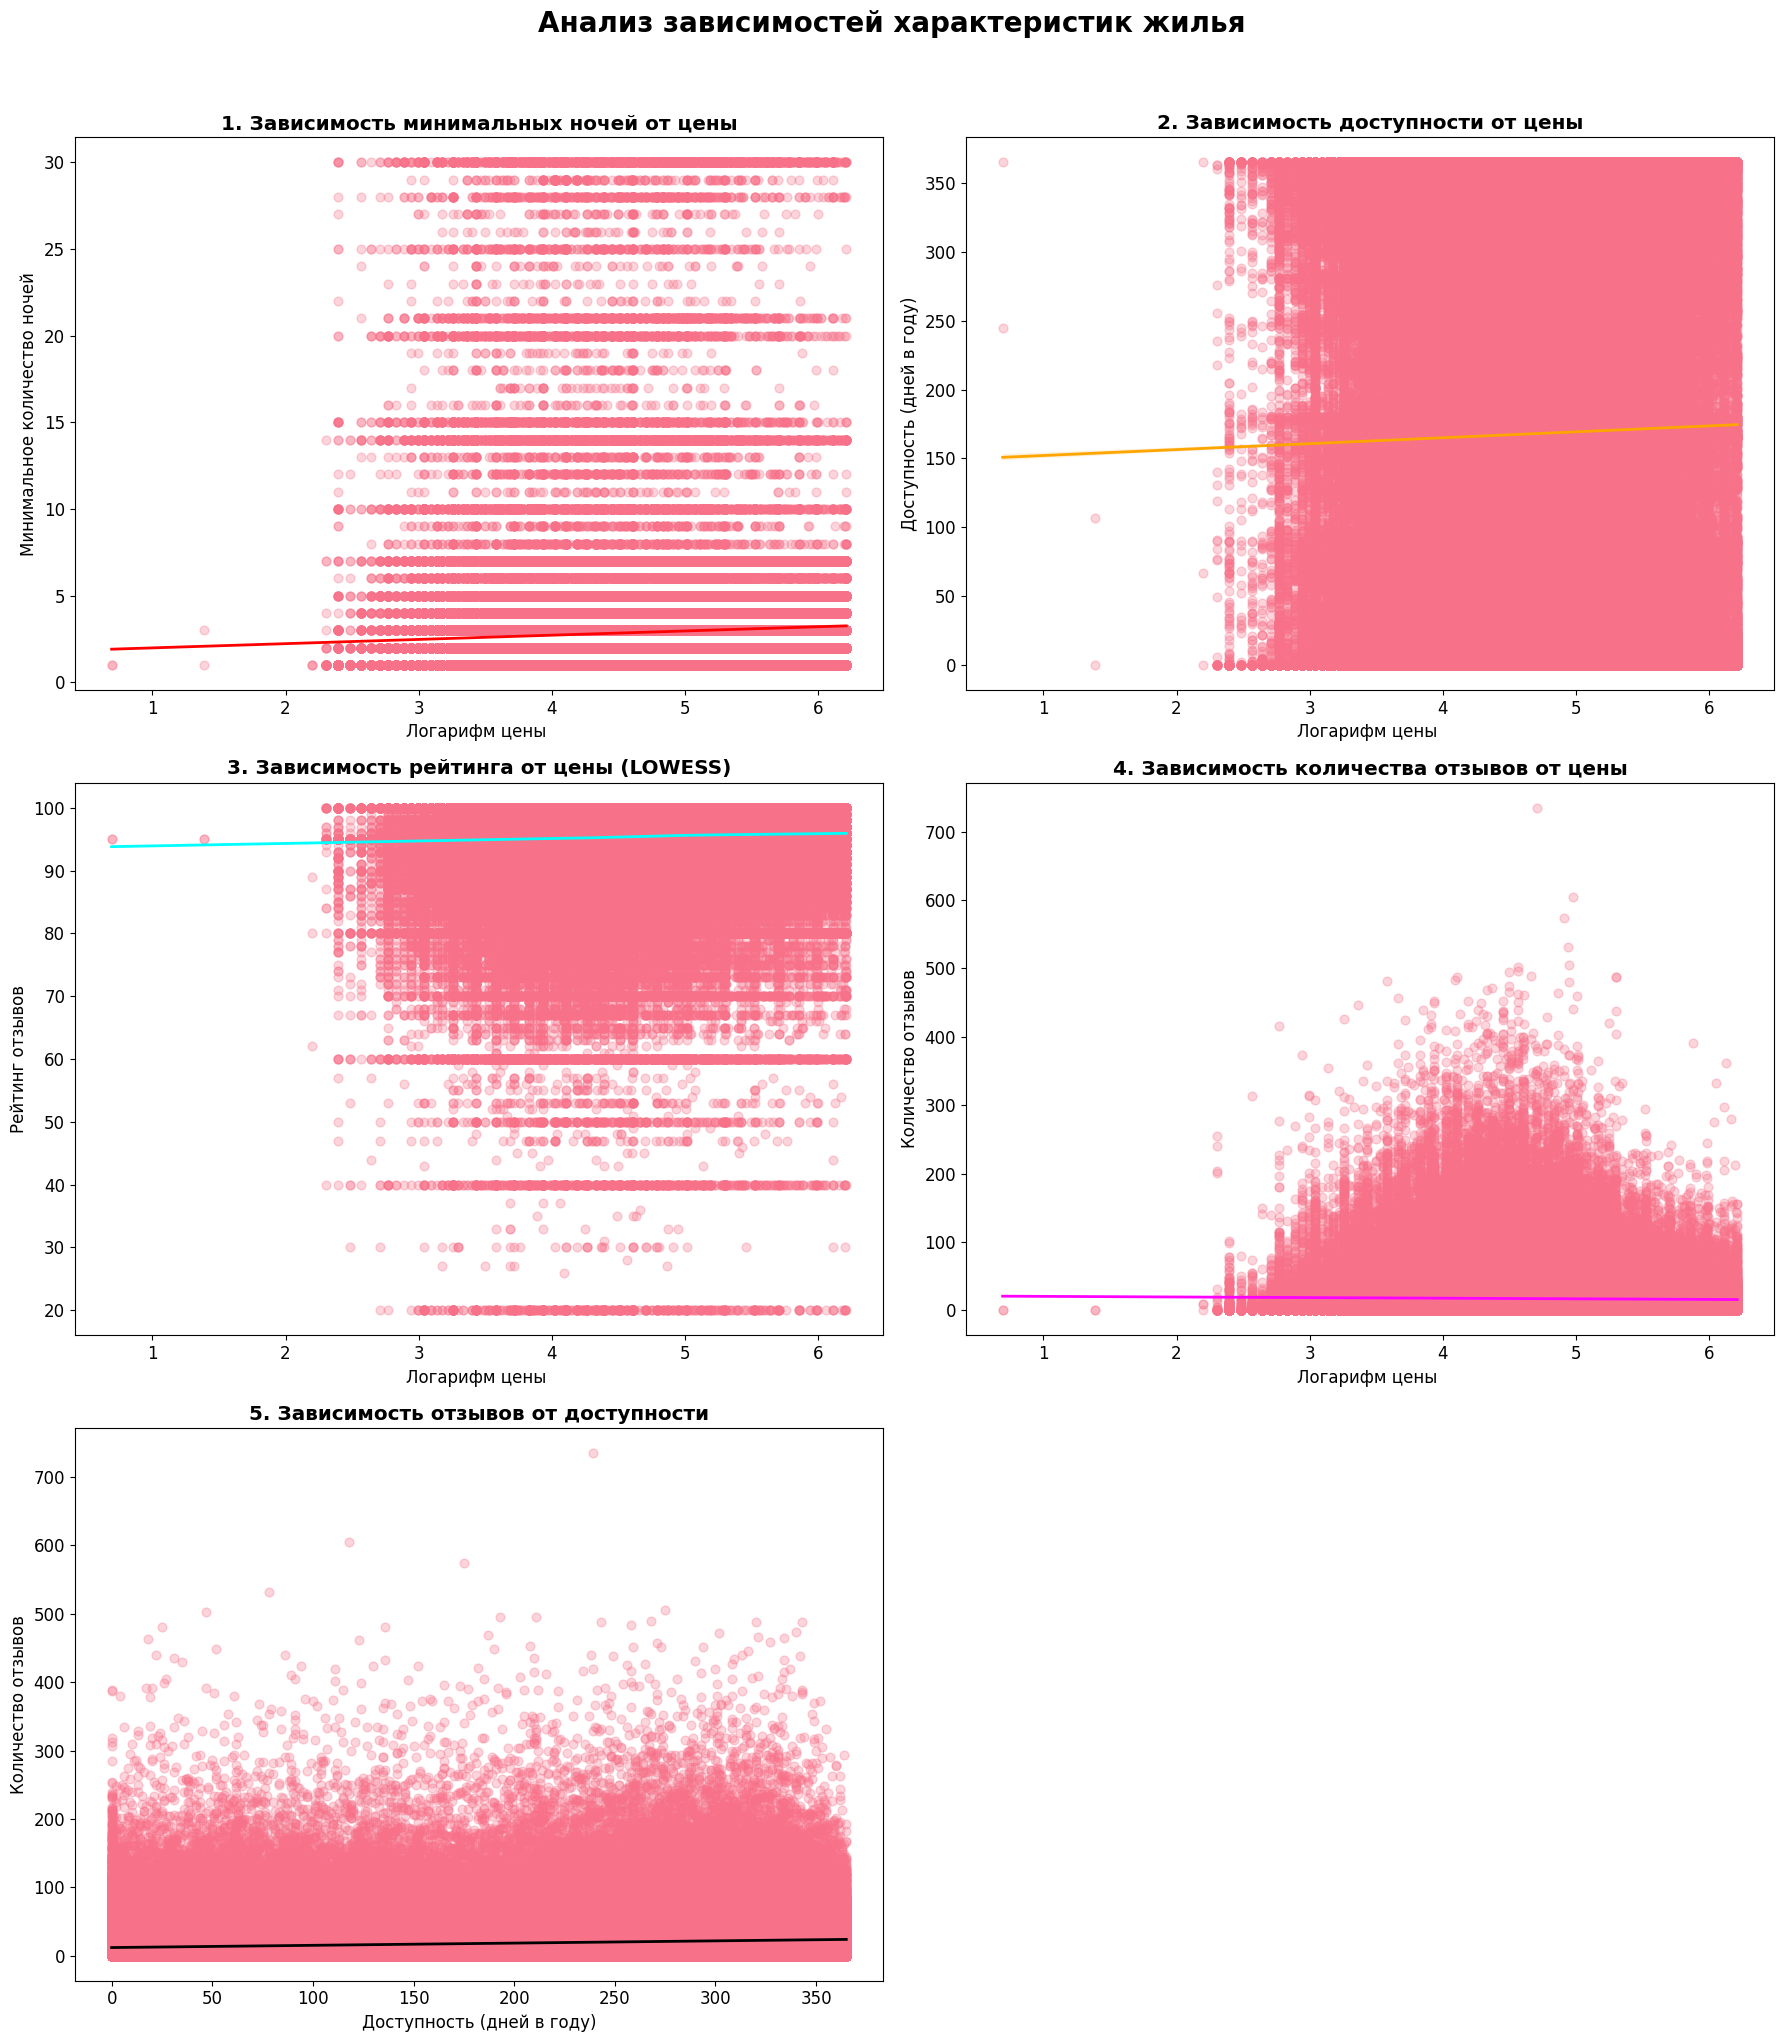

In [ ]:
sns.set_palette("husl")
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'

plot_df = df[['Price', 'Minimum Nights', 'Availability 365',
             'Review Scores Rating', 'Number of Reviews']].copy()
plot_df = plot_df[plot_df['Minimum Nights'] <= 30]
plot_df = plot_df[plot_df['Price'] < 500]
plot_df['Log_Price'] = np.log1p(plot_df['Price'])

fig, axes = plt.subplots(3, 2, figsize=(18, 20))

# 1. Минимальное количество ночей vs цена
sns.regplot(x='Log_Price', y='Minimum Nights', data=plot_df,
           scatter_kws={'alpha':0.3, 's':40},
           line_kws={'color':'red', 'lw':2},
           ci=95,
           ax=axes[0,0])
axes[0,0].set_title('1. Зависимость минимальных ночей от цены', fontweight='bold')
axes[0,0].set_xlabel('Логарифм цены ')
axes[0,0].set_ylabel('Минимальное количество ночей')

# 2. Доступность vs цена
sns.regplot(x='Log_Price', y='Availability 365', data=plot_df,
           scatter_kws={'alpha':0.3, 's':40},
           line_kws={'color':'orange', 'lw':2},
           ci=95,
           ax=axes[0,1])
axes[0,1].set_title('2. Зависимость доступности от цены', fontweight='bold')
axes[0,1].set_xlabel('Логарифм цены ')
axes[0,1].set_ylabel('Доступность (дней в году)')

# 3. Рейтинг vs цена
sns.regplot(x='Log_Price', y='Review Scores Rating', data=plot_df,
           lowess=True,
           scatter_kws={'alpha':0.3, 's':40},
           line_kws={'color':'cyan', 'lw':2},
           ax=axes[1,0])
axes[1,0].set_title('3. Зависимость рейтинга от цены (LOWESS)', fontweight='bold')
axes[1,0].set_xlabel('Логарифм цены ')
axes[1,0].set_ylabel('Рейтинг отзывов')

# 4. Количество отзывов vs цена
sns.regplot(x='Log_Price', y='Number of Reviews', data=plot_df,
           scatter_kws={'alpha':0.3, 's':40},
           line_kws={'color':'magenta', 'lw':2},
           ci=95,
           ax=axes[1,1])
axes[1,1].set_title('4. Зависимость количества отзывов от цены', fontweight='bold')
axes[1,1].set_xlabel('Логарифм цены ')
axes[1,1].set_ylabel('Количество отзывов')

# 5. Количество отзывов vs доступность
sns.regplot(x='Availability 365', y='Number of Reviews', data=plot_df,
           scatter_kws={'alpha':0.3, 's':40},
           line_kws={'color':'black', 'lw':2},
           ci=95,
           ax=axes[2,0])
axes[2,0].set_title('5. Зависимость отзывов от доступности', fontweight='bold')
axes[2,0].set_xlabel('Доступность (дней в году)')
axes[2,0].set_ylabel('Количество отзывов')
axes[2,1].axis('off')

plt.suptitle('Анализ зависимостей характеристик жилья', y=1.02, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
median_reviews = df['Number of Reviews'].median()
df['Is_Popular'] = (df['Number of Reviews'] > median_reviews).astype(int)

features = [
    'Price',
    'Smart Location',
    'Room Type',
    'Property Type',
    'Bed Type',
    'Availability 365',
    'Minimum Nights',
    'Review Scores Rating',
    'Cancellation Policy'
]

categorical_cols = [
    'Smart Location',
    'Room Type',
    'Property Type',
    'Bed Type',
    'Cancellation Policy'
]

def safe_get_dummies(data, cols, max_categories=10):
    for col in cols:
        if data[col].nunique() > max_categories:
            top_categories = data[col].value_counts().head(max_categories-1).index
            data[col] = data[col].where(data[col].isin(top_categories), 'Other')
    return pd.get_dummies(data, columns=cols, drop_first=True)

X = safe_get_dummies(df[features], categorical_cols)
y = df['Is_Popular']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

<ipython-input-9-019c9522d651>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].where(data[col].isin(top_categories), 'Other')
<ipython-input-9-019c9522d651>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].where(data[col].isin(top_categories), 'Other')
<ipython-input-9-019c9522d651>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

              precision    recall  f1-score   support

           0       0.68      0.56      0.62     73466
           1       0.62      0.73      0.67     71228

    accuracy                           0.64    144694
   macro avg       0.65      0.65      0.64    144694
weighted avg       0.65      0.64      0.64    144694



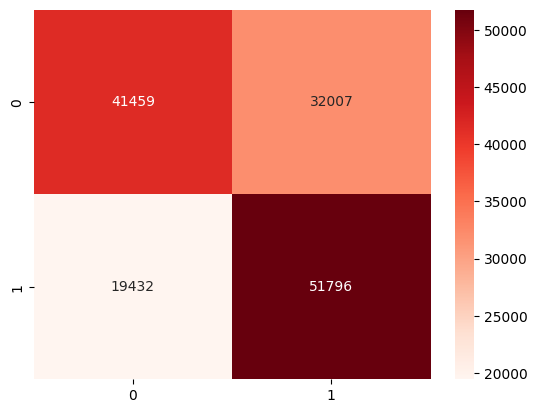

In [ ]:
logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])
logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)
print(classification_report(y_test, y_pred_lr))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Reds')
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83     73466
           1       0.83      0.82      0.83     71228

    accuracy                           0.83    144694
   macro avg       0.83      0.83      0.83    144694
weighted avg       0.83      0.83      0.83    144694



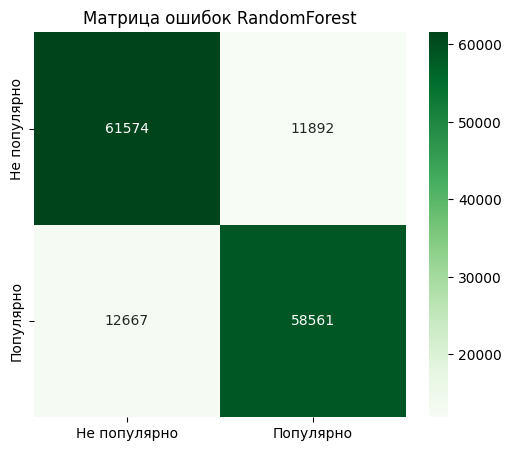

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
            annot=True, fmt='d', cmap='Greens',
            xticklabels=['Не популярно', 'Популярно'],
            yticklabels=['Не популярно', 'Популярно'])
plt.title('Матрица ошибок RandomForest')
plt.show()

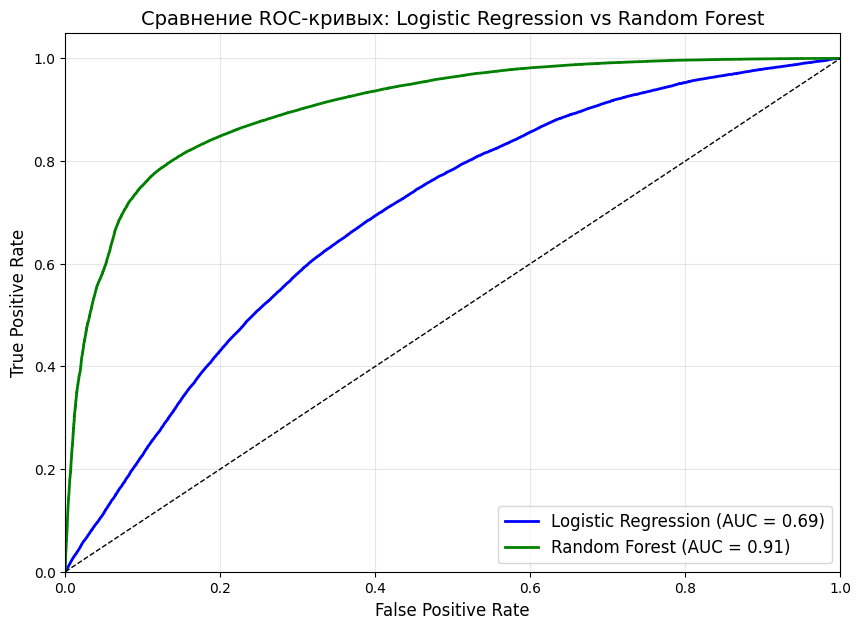

,Accuracy,Precision,Recall,F1,ROC AUC
Logistic Regression,0.644498,0.618069,0.727186,0.668202,0.693914
Random Forest,0.830269,0.831207,0.822163,0.826660,0.905522


In [ ]:
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
)
logreg.fit(X_train, y_train)

y_proba_lr = logreg.predict_proba(X_test)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(10, 7))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr,
         label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})',
         color='blue',
         linewidth=2)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf,
         label=f'Random Forest (AUC = {roc_auc_rf:.2f})',
         color='green',
         linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Сравнение ROC-кривых: Logistic Regression vs Random Forest', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


metrics = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, logreg.predict(X_test)),
        'Precision': precision_score(y_test, logreg.predict(X_test)),
        'Recall': recall_score(y_test, logreg.predict(X_test)),
        'F1': f1_score(y_test, logreg.predict(X_test)),
        'ROC AUC': roc_auc_lr
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_test, rf_model.predict(X_test)),
        'Precision': precision_score(y_test, rf_model.predict(X_test)),
        'Recall': recall_score(y_test, rf_model.predict(X_test)),
        'F1': f1_score(y_test, rf_model.predict(X_test)),
        'ROC AUC': roc_auc_rf
    }
}

pd.DataFrame(metrics).T.style.background_gradient(cmap='YlOrBr', subset=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'])

In [ ]:
y_price = df['Price']
X_features = df.drop('Price', axis=1)

X_processed = safe_get_dummies(X_features, categorical_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_price, test_size=0.3, random_state=42
)

Linear Regression Performance:
RMSE: 117.54
R2 Score: 0.19


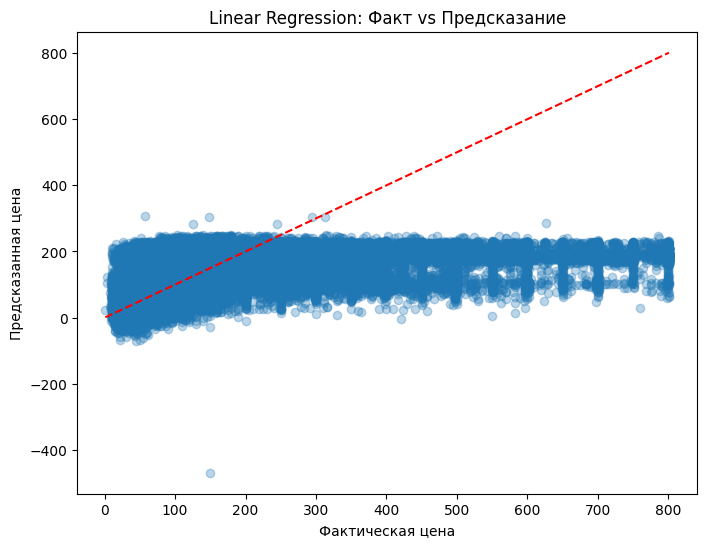

In [ ]:
lr_model = make_pipeline(
    StandardScaler(),
    LinearRegression()
)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

print("Linear Regression Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred_lr):.2f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактическая цена')
plt.ylabel('Предсказанная цена')
plt.title('Linear Regression: Факт vs Предсказание')
plt.show()

XGBoost Regressor Performance:
RMSE: 111.68
R2 Score: 0.27


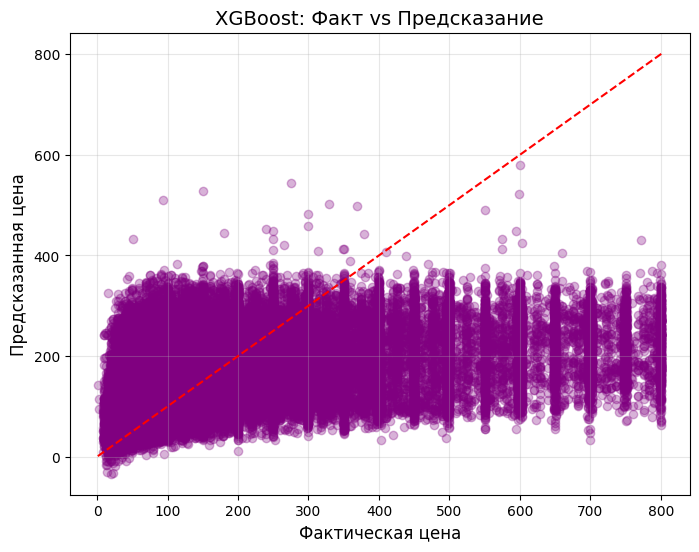

In [ ]:
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Regressor Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred_xgb):.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактическая цена', fontsize=12)
plt.ylabel('Предсказанная цена', fontsize=12)
plt.title('XGBoost: Факт vs Предсказание', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()